In [31]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import binarize
from sklearn.preprocessing import MinMaxScaler, StandardScaler # min/max scaling
import pickle
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from mapseq_fxns import * # import all functions from this script
# from math import log10
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap



# random sample consimment between runs
import random



%matplotlib inline


In [3]:


# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
out_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/output/'

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp


# Normalized count data


In [4]:
#### load data
with open(in_path +'M194_M220_OMC_countN4.pkl', 'rb') as f:
    omc_countN = pickle.load(f)



In [5]:

omc_countN = [clean_up_data(df) for df in omc_countN]

omc_values = []
for i in range(num_samples):
    values = omc_countN[i].values
    flat = values.flatten() # make single array
    # nzeros = flat.nonzero() # drop zeros to find range
    # omc_values.append(nzeros)
    omc_values.append(flat)



# omc_countN[0]

Text(0.5, 0.98, 'With zeros')

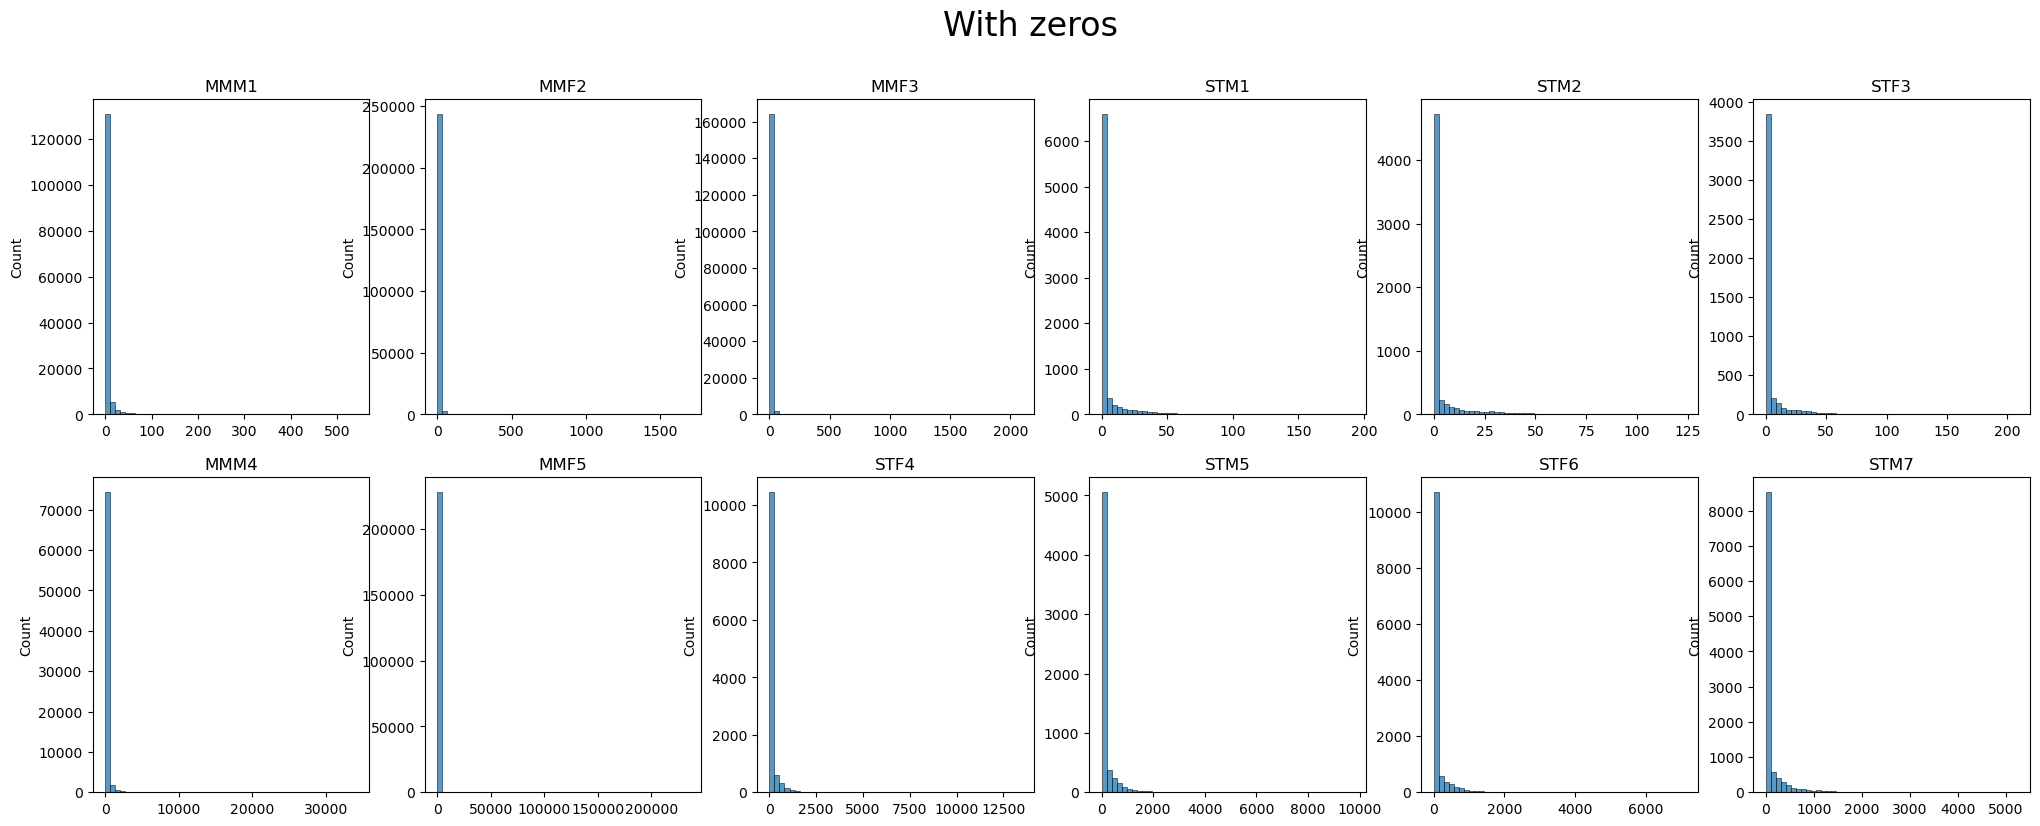

In [13]:
# plot histogram of count values
fig, axs = plt.subplots(2,6, figsize=(25,9))
i=0
for ax in axs.flat:
    sns.histplot(omc_values[i], bins = 50, legend=False, ax=ax)
    ax.set_title(mice[i])
    i+=1
fig.suptitle("With zeros", size=24)

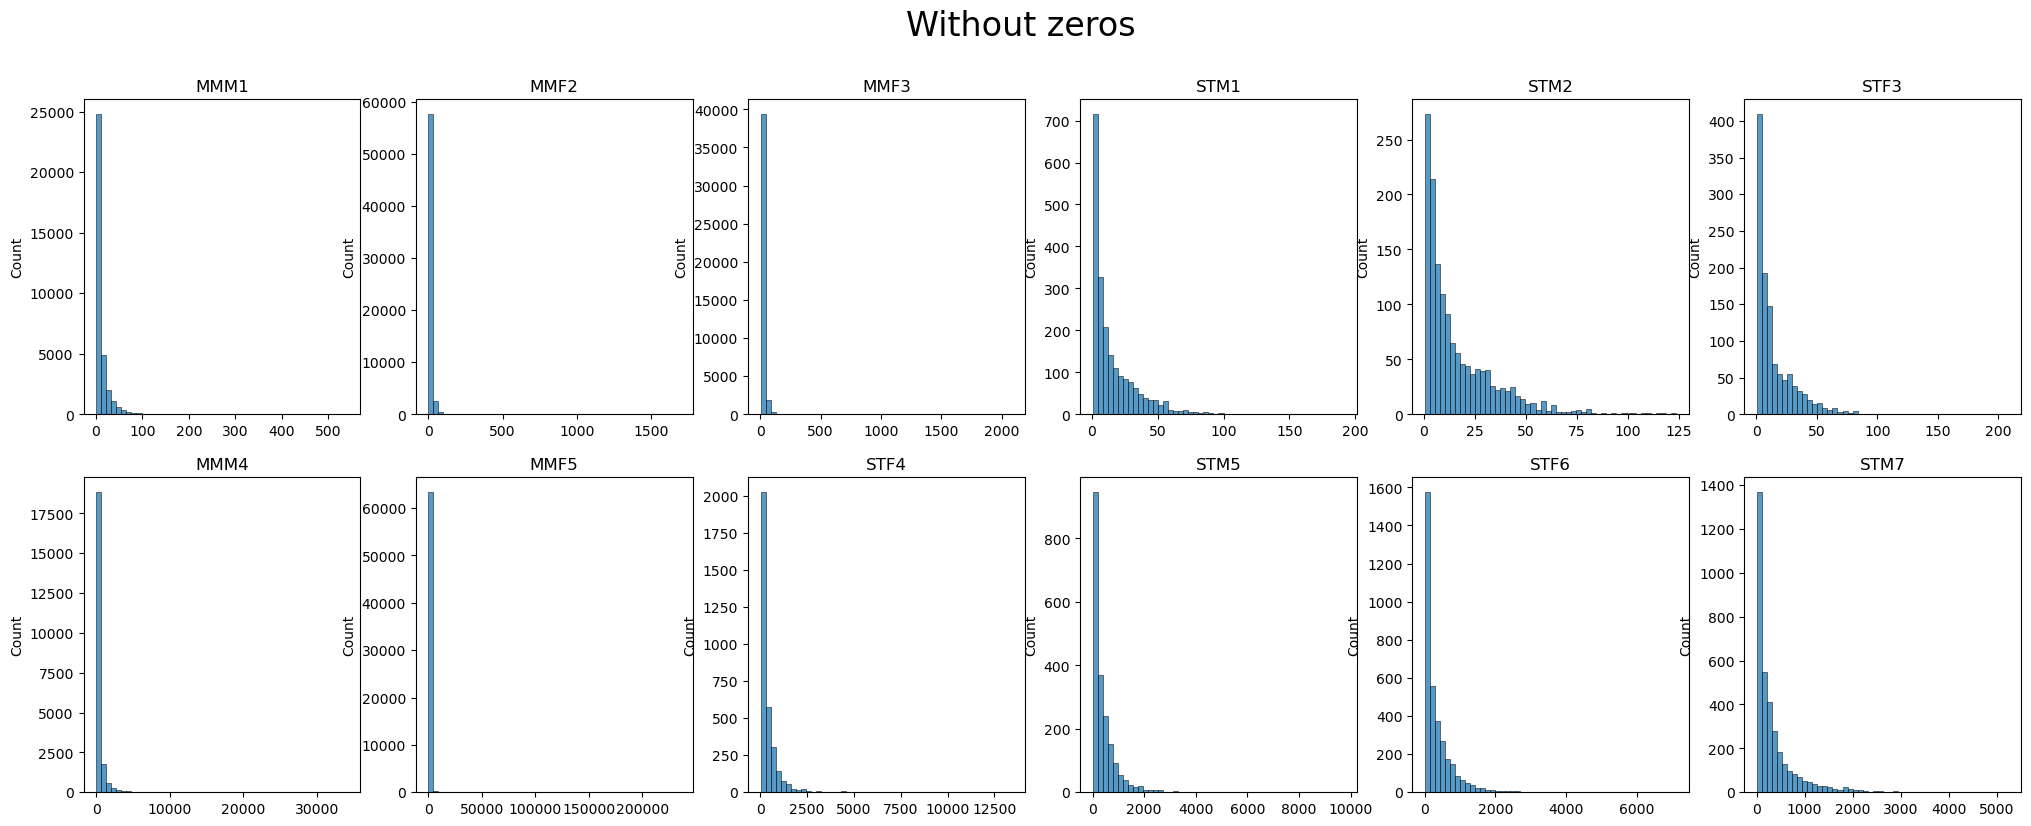

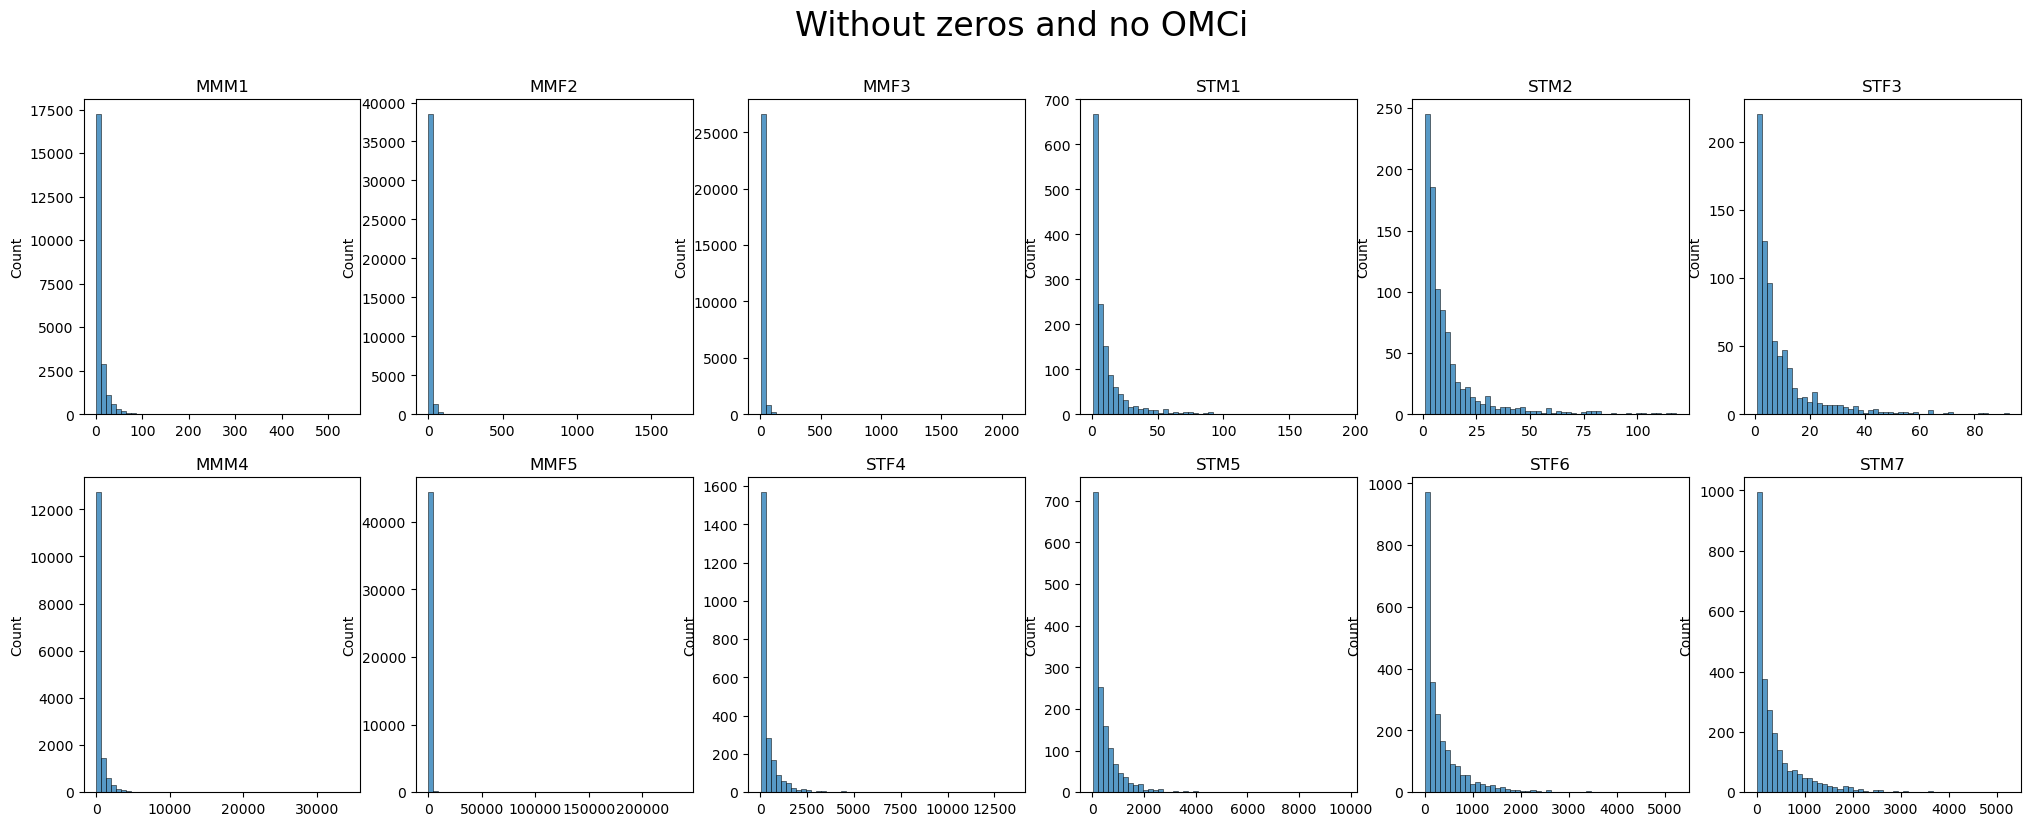

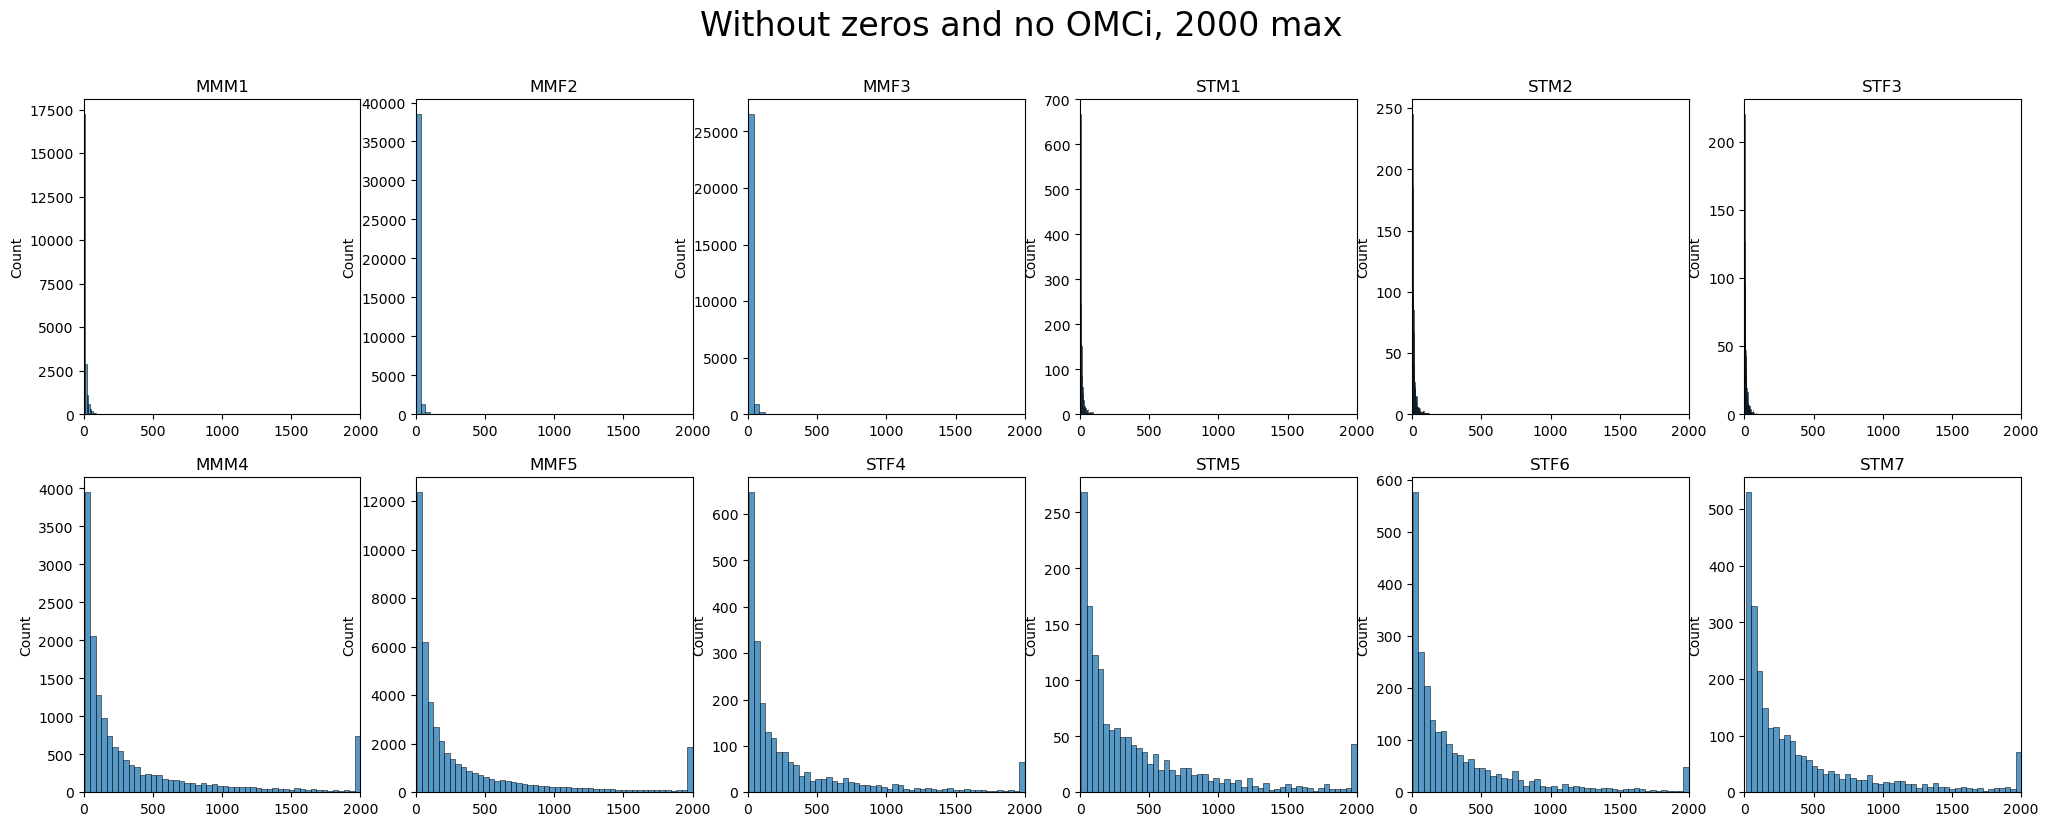

In [19]:
# plot = []
# for i in range(num_samples):
#     plot.append(omc_values[i].nonzero())

# plot histogram of count values
fig, axs = plt.subplots(2,6, figsize=(25,9))
i=0
for ax in axs.flat:
    idx = omc_values[i].nonzero()
    plot = omc_values[i][idx]
    sns.histplot(plot, bins = 50, legend=False, ax=ax)
    ax.set_title(mice[i])
    i+=1
fig.suptitle("Without zeros", size=24)
plt.show()

# drop OMCi
fig, axs = plt.subplots(2,6, figsize=(25,9))
i=0
for ax in axs.flat:
    df = omc_countN[i].drop("OMCi", axis=1)
    vals = df.values.flatten()
    idx = vals.nonzero()
    plot = vals[idx]
    sns.histplot(plot, bins = 50, legend=False, ax=ax)
    ax.set_title(mice[i])
    i+=1
fig.suptitle("Without zeros and no OMCi", size=24)
plt.show()

# create cut-off so histograms on similar scale
fig, axs = plt.subplots(2,6, figsize=(25,9))
i=0
for ax in axs.flat:
    df = omc_countN[i].drop("OMCi", axis=1)
    vals = df.values.flatten()
    idx = vals.nonzero()
    plot = vals[idx]
    plot[plot > 2000] = 2000
    sns.histplot(plot, bins = 50, legend=False, ax=ax)
    ax.set_title(mice[i])
    ax.set_xlim(0,2000)
    i+=1
fig.suptitle("Without zeros and no OMCi, 2000 max", size=24)
plt.show()

# Aggregate data

In [11]:
omc_mm = []
omc_st = []
for i in range(num_samples):
    if species[i] == "MMus":
        omc_mm.append(omc_countN[i])
    else:
        omc_st.append(omc_countN[i])

omc_mm_all = pd.concat(omc_mm)
omc_st_all = pd.concat(omc_st)

# Covariance/correlation

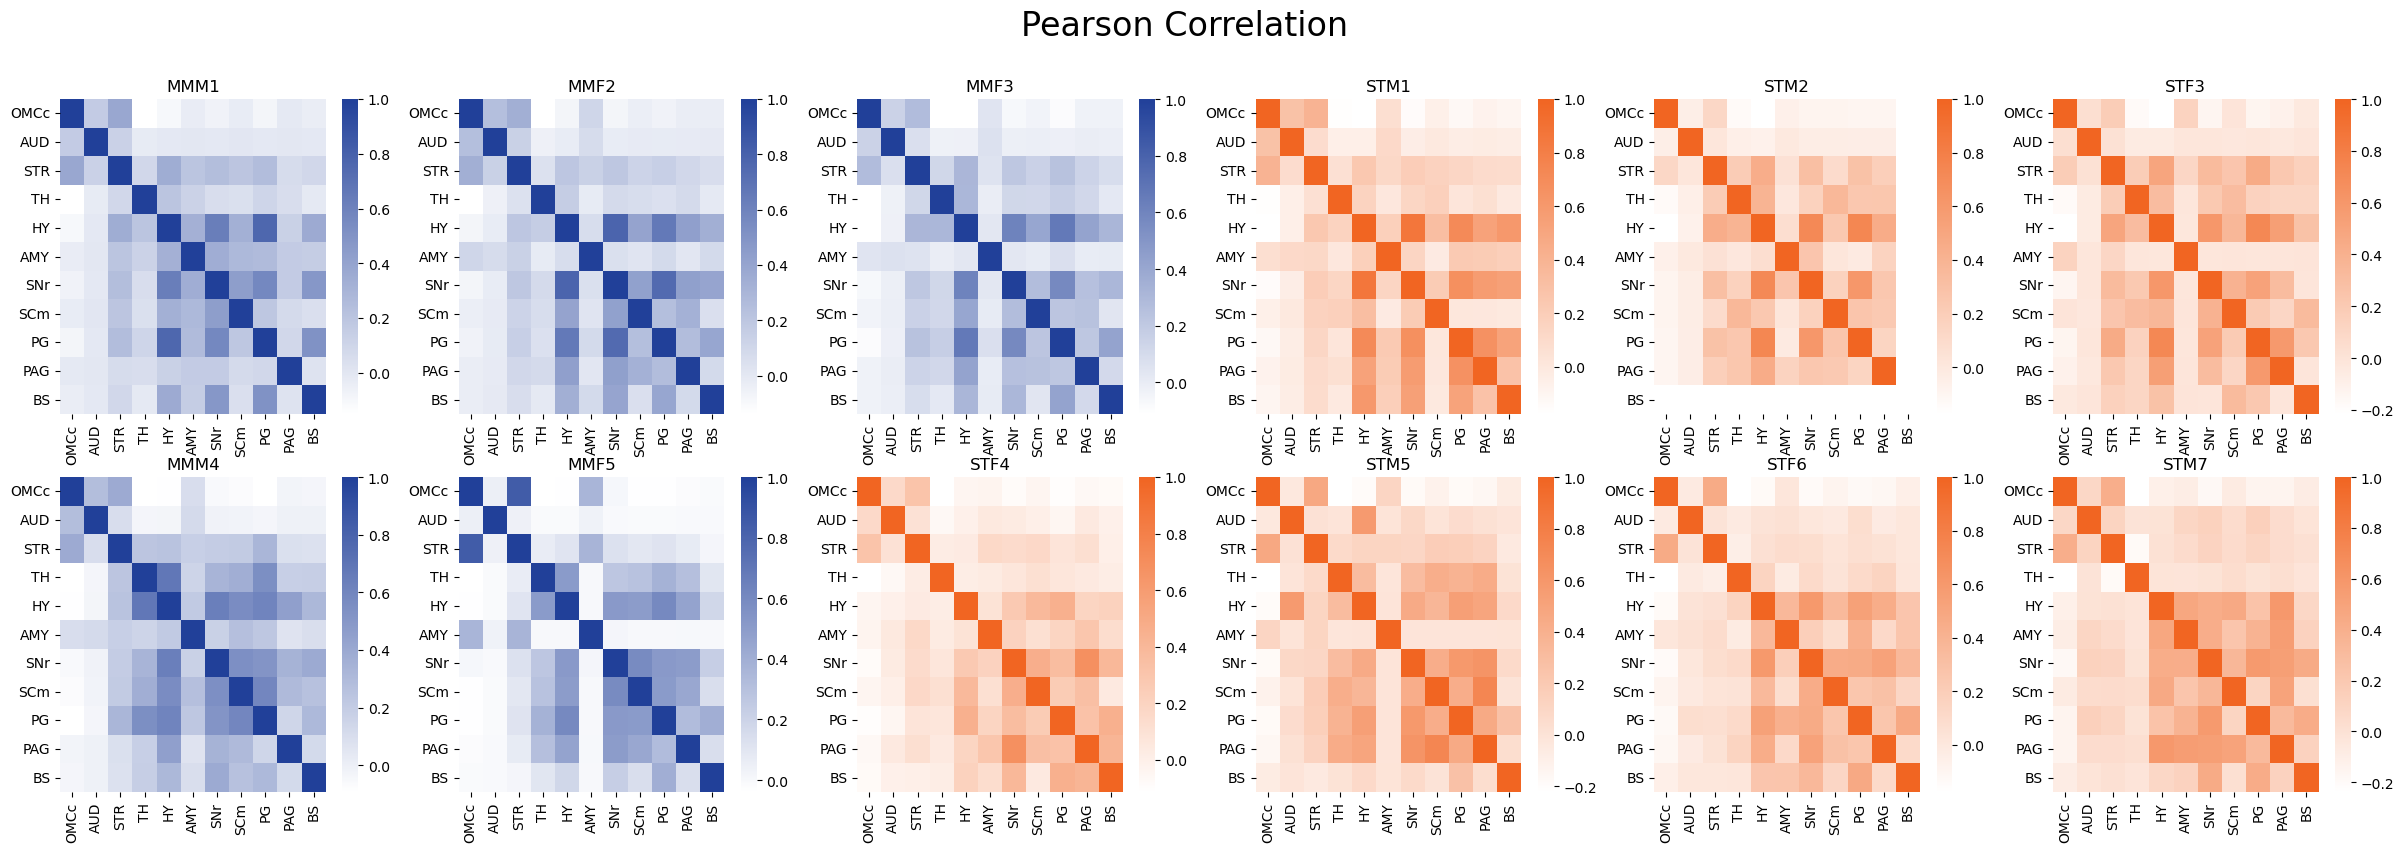

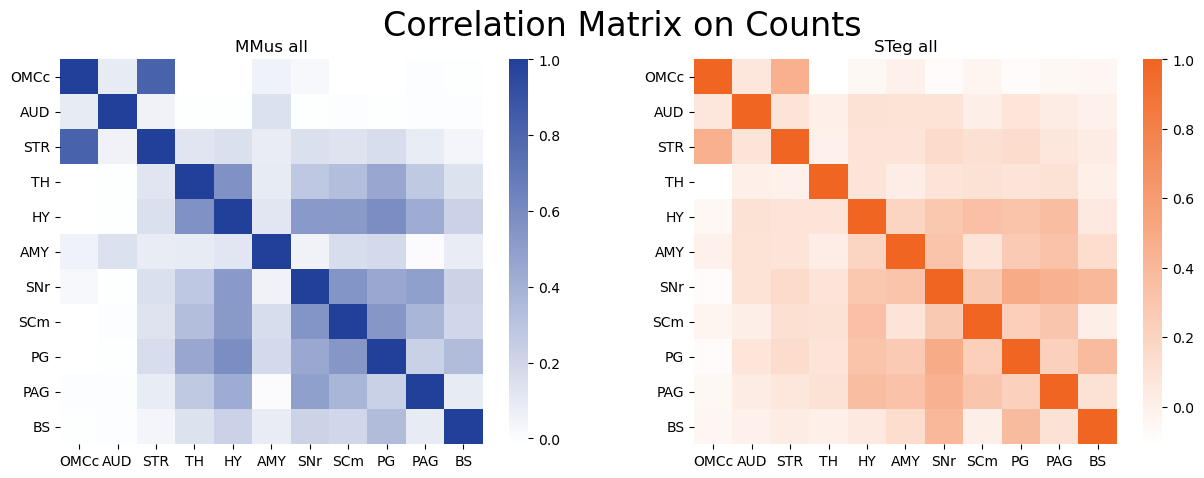

In [23]:

# correlation plots
fig, axs = plt.subplots(2, 6, figsize=(30,9))
i=0
for ax in axs.flat:
    df = omc_countN[i].drop("OMCi", axis=1)
    if species[i]=="MMus":
        sns.heatmap(df.corr(), cmap=blue_cmp, ax=ax)
    else:
        sns.heatmap(df.corr(), cmap=orange_cmp, ax=ax)
    ax.set_title(mice[i])
    
    i+=1
plt.suptitle("Pearson Correlation",size=24)
plt.show()



# aggregated correlation plots
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.heatmap(omc_mm_all.drop("OMCi", axis=1).corr(), cmap=blue_cmp, ax=axs[0])
axs[0].set_title("MMus all")

sns.heatmap(omc_st_all.drop("OMCi", axis=1).corr(), cmap=orange_cmp, ax=axs[1])
axs[1].set_title("STeg all")

plt.suptitle("Correlation Matrix on Counts",size=24)
plt.show()


# PCA

In [6]:
sorted = [sort_by_celltype(df, pt_areas=["AMY", "SNr", "SCm", "PG", "PAG", "BS"]) for df in omc_countN]

omc_mm_sort = []
omc_st_sort = []
for i in range(num_samples):
    df = sorted[i].copy()
    df['mice'] = mice[i]
    df['dataset'] = dataset[i]
    df['species'] = species[i]

    if species[i] == "MMus":
        omc_mm_sort.append(df)
    else:
        omc_st_sort.append(df)

sorted_mm_all = pd.concat(omc_mm_sort)
sorted_st_all = pd.concat(omc_st_sort)


In [7]:
# # save as csv for arka
# sorted_mm_all.to_csv(out_path+'mmus_all.csv', index=False)
# sorted_st_all.to_csv(out_path+'steg_all.csv', index=False)


(71594, 12)
(71594, 12)
10      53520
100      9583
1000     8491
Name: type, dtype: int64


<AxesSubplot: xlabel='C0', ylabel='C1'>

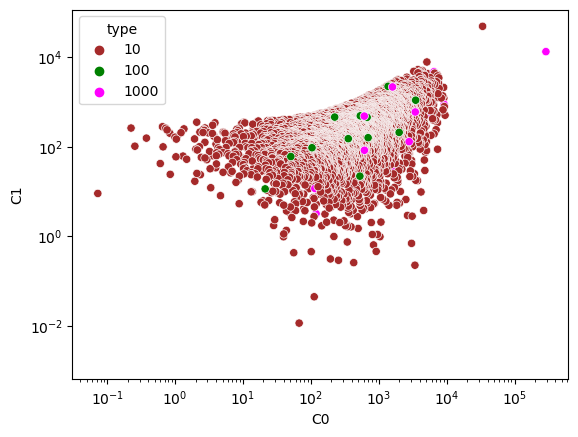

In [51]:
# create PCA component labels
com_labels = []
for i in range(12):
    com_labels.append('C'+str(i))

# specify colors for cell types
color_dict = {10:'brown', 100:'green', 1000:'magenta'}

pca = PCA()
mm_type = sorted_mm_all['type'].reset_index(drop=True)
mm_plot = sorted_mm_all.drop("type", axis=1)
components = pca.fit_transform(mm_plot)
print(mm_plot.shape)
print(components.shape)
components[:,0].shape
plot = pd.DataFrame(components, columns = com_labels)
plot['type'] = mm_type

print(mm_type.value_counts())


g = sns.scatterplot(plot, x="C0", y="C1", hue="type", palette=color_dict)
g.set(xscale='log', yscale='log')
g


<AxesSubplot: xlabel='C1', ylabel='C2'>

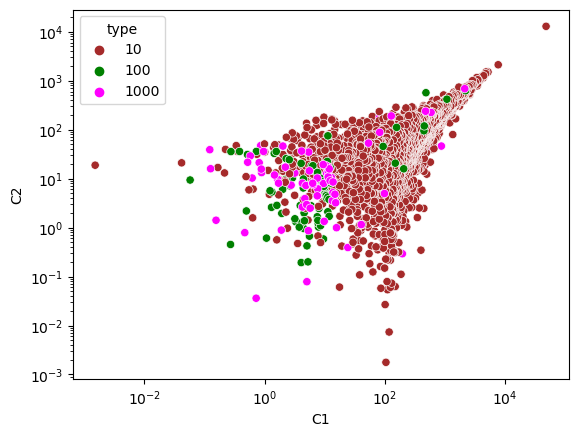

In [65]:
g = sns.scatterplot(plot, x="C1", y="C2", hue="type", palette=color_dict)
g.set(xscale='log', yscale='log')
g

In [60]:
com_var = pca.explained_variance_ratio_
print("Explained Variance per Component")
for i in range(com_var.shape[0]):
    print(com_labels[i], "\t", com_var[i]*100)

Explained Variance per Component
C0 	 86.29967896217123
C1 	 7.969536969845119
C2 	 2.835963179868398
C3 	 1.266765870269579
C4 	 1.1864539024801068
C5 	 0.1918229028299371
C6 	 0.13822015167608712
C7 	 0.04648961988229671
C8 	 0.030033577461432044
C9 	 0.020431818594699603
C10 	 0.013413667372544699
C11 	 0.0011893775485476371


In [41]:
print(plot.shape)
mm_type

(71594, 12)


0          10
1          10
2          10
3          10
4          10
         ... 
18990    1000
18991    1000
18992    1000
18993    1000
18994    1000
Name: type, Length: 71594, dtype: int64

In [67]:
pd.DataFrame(pca.components_)


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.054492,0.553833,0.001090,0.830541,0.011552,0.003118,0.000316,0.005646,0.016450,0.007095,0.001797,0.000351
1,-0.041163,0.802757,0.003604,-0.525132,-0.144018,-0.035351,-0.000865,-0.047050,-0.218195,-0.076845,-0.019230,-0.004669
2,0.179095,0.214090,0.002879,-0.178965,0.363121,0.085455,0.003383,0.136849,0.836771,0.169047,0.056286,0.014987
3,-0.551584,-0.009420,-0.007147,0.043788,-0.702389,-0.043134,-0.000402,0.033696,0.442276,-0.041466,-0.004720,-0.001356
4,-0.811292,0.049547,-0.011051,0.013649,0.570611,0.043021,-0.001203,-0.002863,-0.097342,0.045010,0.008727,0.002493
5,-0.024805,0.020958,-0.000586,-0.017205,-0.150034,0.176501,0.003782,0.437136,-0.203656,0.836850,0.074079,0.081259
6,-0.001641,-0.003017,-0.002732,0.000908,0.015235,0.099467,-0.011576,0.801536,-0.071121,-0.481854,0.331272,-0.016675
7,-0.004617,0.002324,-0.000614,-0.001093,-0.050968,0.308167,-0.003538,-0.374111,-0.014812,0.041964,0.871872,-0.017126
8,0.000148,0.001810,0.001456,-0.001351,-0.054470,0.922675,0.003676,-0.058488,-0.009082,-0.146461,-0.347278,0.011250
9,-0.013415,-0.003638,0.999232,0.001959,0.000742,-0.000814,0.036389,0.002493,0.000025,-0.000932,0.002241,0.000112


In [68]:
sorted_mm_all

,OMCi,OMCc,AUD,STR,TH,HY,AMY,SNr,SCm,PG,PAG,BS,type
0,57.103800,137.127453,0.0,42.190510,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,10
1,96.779518,124.909462,0.0,542.350316,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,10
2,30.845302,123.762430,0.0,53.676099,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,10
3,45.428137,111.553123,0.0,103.713328,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,10
4,2.239510,106.507643,0.0,107.347710,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18990,14.784295,0.000000,0.0,50.460306,48.092869,0.000000,0.0,0.000000,8.460237,14.326648,0.0,0.0,1000
18991,11.134549,0.000000,0.0,26.936027,94.527363,0.000000,0.0,0.000000,10.152284,0.000000,0.0,0.0,1000
18992,18.248617,0.000000,0.0,65.611821,0.000000,17.716535,0.0,0.000000,23.688663,14.326648,0.0,0.0,1000
18993,1269.355626,0.000000,0.0,17677.136817,305.140962,372.047244,0.0,31.531532,323.181049,1220.630372,0.0,0.0,1000


In [9]:
# create PCA component labels
com_labels = []
for i in range(9):
    com_labels.append('C'+str(i))

# specify colors for cell types
color_dict = {10:'brown', 100:'green', 1000:'magenta'}

mm_type = sorted_mm_all['type'].reset_index(drop=True).replace({10:"IT", 100:"CT", 1000:"PT"})
mm_drop = sorted_mm_all.drop(["OMCi", "STR", "TH", "type", "mice", "dataset", "species"], axis=1)

# normalize within row (i.e. within cell/neuron/barcode)
mm_transpose = mm_drop.values.T
sscalar = StandardScaler()
mm_scaled = sscalar.fit_transform(mm_transpose).T
mm_plot = pd.DataFrame(mm_scaled, columns=mm_drop.columns)


(71594, 9)
(71594, 9)
IT    53520
CT     9583
PT     8491
Name: type, dtype: int64


Text(0.5, 0.98, 'MMus all cells - PCA')

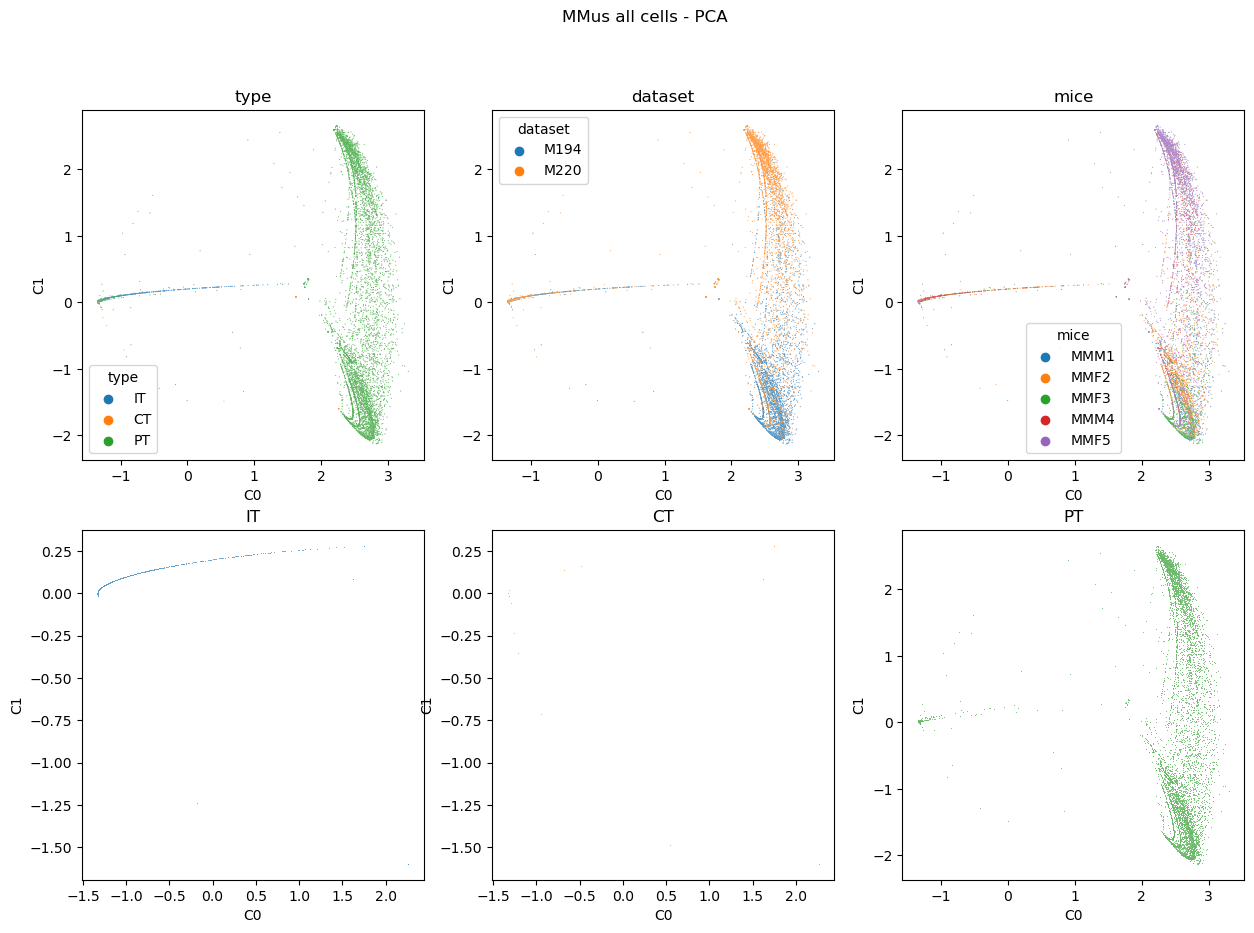

In [13]:

# run PCA on normalized data
pca = PCA()
components = pca.fit_transform(mm_plot)
print(mm_plot.shape)
print(components.shape)
components[:,0].shape
plot = pd.DataFrame(components, columns = com_labels)
plot['type'] = mm_type
plot['species'] = sorted_mm_all['species'].reset_index(drop=True)
plot["mice"] = sorted_mm_all['mice'].reset_index(drop=True)
plot["dataset"] = sorted_mm_all['dataset'].reset_index(drop=True)

print(mm_type.value_counts())


plot_vars = ["type", "dataset", "mice"]
fig, axs = plt.subplots(2,3, figsize=(15,10))
i=0
for ax in axs[0,:]:
    sns.scatterplot(plot, x="C0", y="C1", hue=plot_vars[i], s=0.5, ax=ax)
    # ax.set_xlim(-50,3000)
    # ax.set_ylim(-50,3000)
    # g.set(xscale='log', yscale='log')
    ax.set_title(plot_vars[i])
    i+=1

type_vars = ["IT", "CT", "PT"]
i=0
for ax in axs[1,:]:
    cell = type_vars[i]
    type_plot = plot[plot["type"] == cell]
    color = sns.color_palette("tab10")
    sns.scatterplot(type_plot, x="C0", y="C1", color=color[i], s=0.5, ax=ax)
    ax.set_title(cell)
    i+=1


plt.suptitle("MMus all cells - PCA")



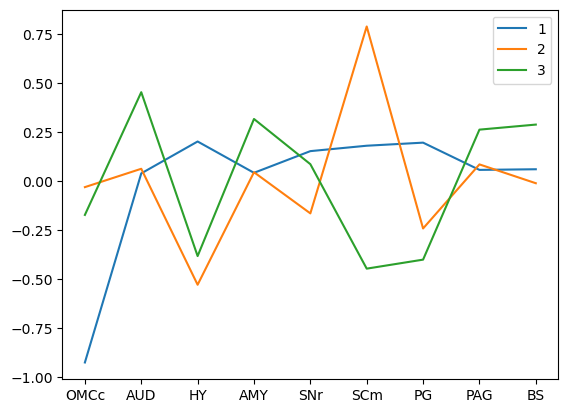

In [11]:
int = pca.components_

labels = ['OMCc', 'AUD', 'HY', 'AMY', 'SNr', 'SCm', 'PG', 'PAG', 'BS']
nums = list(range(9))

# rows
for i in range(3):
    plt.plot(int[i], label=str(i+1))
plt.xticks(nums,['OMCc', 'AUD', 'HY', 'AMY', 'SNr', 'SCm', 'PG', 'PAG', 'BS'])
plt.legend()
plt.show()

# for i in range(3):
#     plt.plot(int[:,i])
# plt.show()



# TSNE

/Users/eisko/miniconda3/envs/MAPseq/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eisko/miniconda3/envs/MAPseq/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(71594, 9)
(71594, 2)
IT    53520
CT     9583
PT     8491
Name: type, dtype: int64


Text(0.5, 0.98, 'MMus all cells - TSNE')

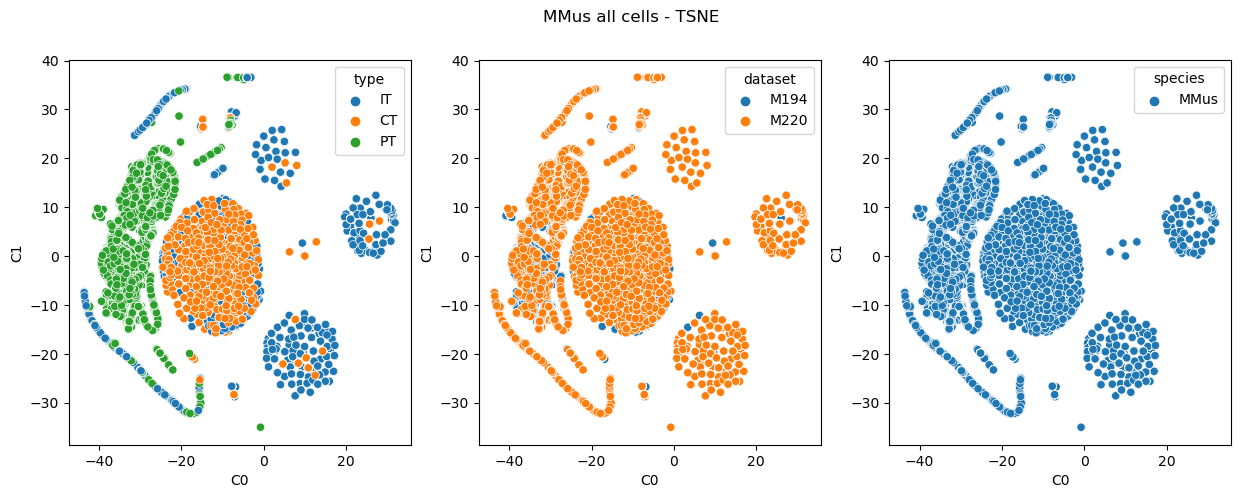

In [53]:
# try umap/tsne
tsne = TSNE()
components = tsne.fit_transform(mm_plot)
print(mm_plot.shape)
print(components.shape)
plot = pd.DataFrame(components, columns = ["C0", "C1"])
plot['type'] = mm_type
plot['species'] = sorted_mm_all['species'].reset_index(drop=True)
plot["mice"] = sorted_mm_all['mice'].reset_index(drop=True)
plot["dataset"] = sorted_mm_all['dataset'].reset_index(drop=True)

print(mm_type.value_counts())



plot_vars = ["type", "dataset", "species"]
fig, axs = plt.subplots(1,3, figsize=(15,5))
i=0
for ax in axs.flat:
    sns.scatterplot(plot, x="C0", y="C1", hue=plot_vars[i], ax=ax)
    # ax.set_xlim(-50,3000)
    # ax.set_ylim(-50,3000)
    # g.set(xscale='log', yscale='log')
    # ax.set_title(plot_vars[i])
    i+=1
plt.suptitle("MMus all cells - TSNE")


Text(0.5, 0.98, 'MMus all cells - TSNE')

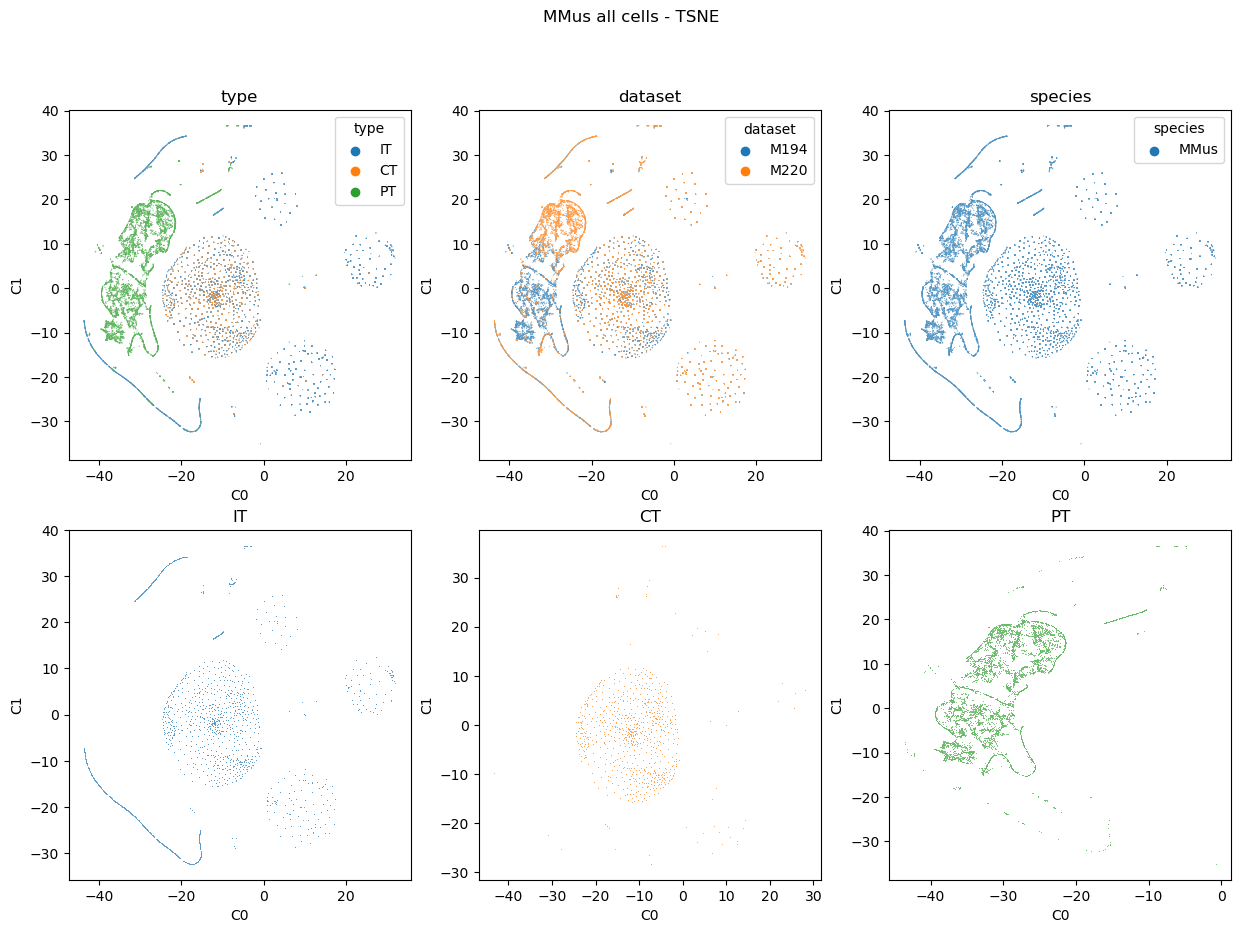

In [60]:
plot_vars = ["type", "dataset", "species"]
fig, axs = plt.subplots(2,3, figsize=(15,10))
i=0
for ax in axs[0,:]:
    sns.scatterplot(plot, x="C0", y="C1", hue=plot_vars[i], s=0.5, ax=ax)
    # ax.set_xlim(-50,3000)
    # ax.set_ylim(-50,3000)
    # g.set(xscale='log', yscale='log')
    ax.set_title(plot_vars[i])
    i+=1

type_vars = ["IT", "CT", "PT"]
i=0
for ax in axs[1,:]:
    cell = type_vars[i]
    type_plot = plot[plot["type"] == cell]
    color = sns.color_palette("tab10")
    sns.scatterplot(type_plot, x="C0", y="C1", color=color[i], s=0.5, ax=ax)
    ax.set_title(cell)
    i+=1


plt.suptitle("MMus all cells - TSNE")

In [55]:
sns.color_palette("tab10")[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

(71594, 9)
(71594, 2)
IT    53520
CT     9583
PT     8491
Name: type, dtype: int64


Text(0.5, 0.98, 'MMus all cells - UMAP')

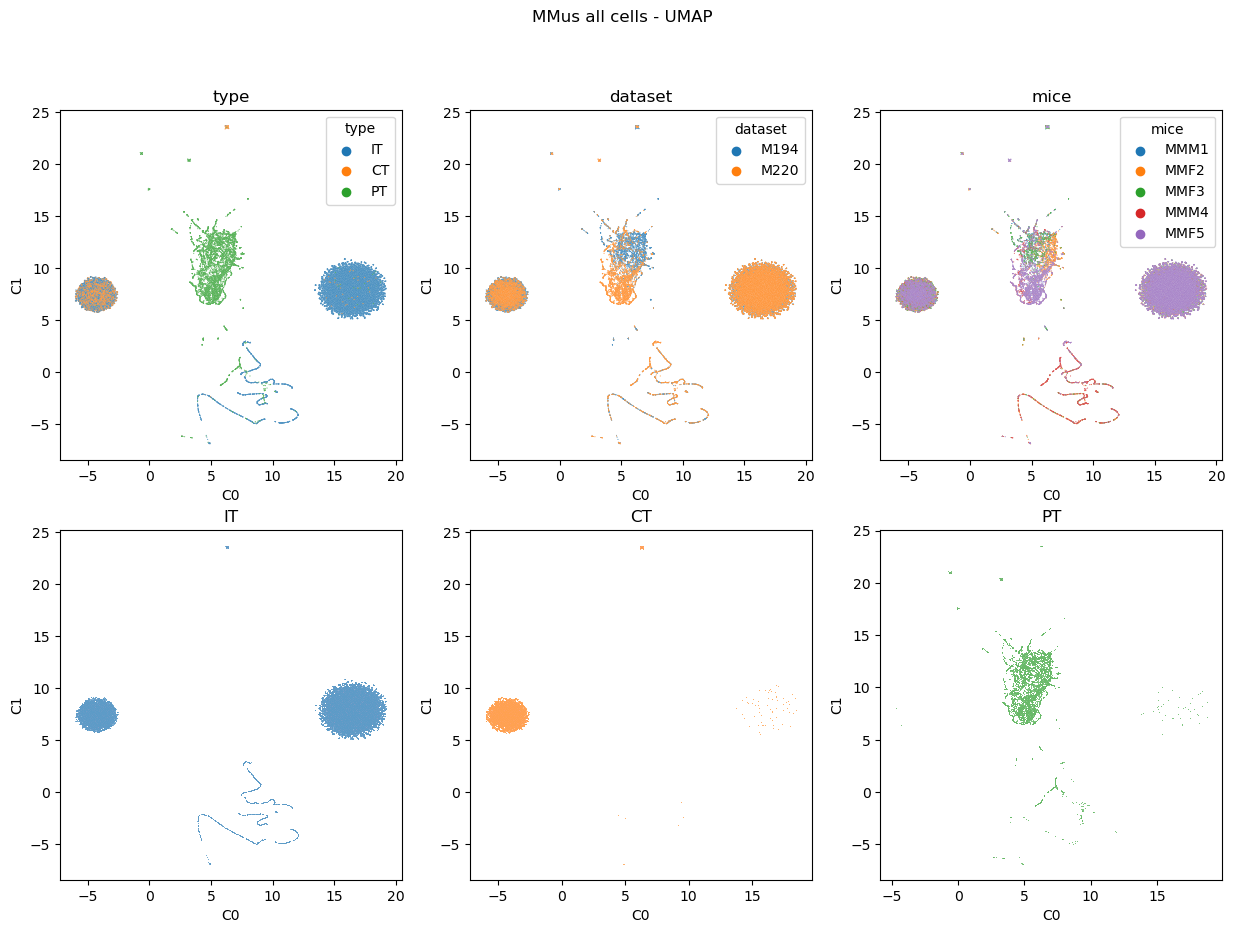

In [12]:
# try umap/
umap = umap.UMAP()
embedding = umap.fit_transform(mm_plot)
print(mm_plot.shape)
print(embedding.shape)
plot = pd.DataFrame(embedding, columns = ["C0", "C1"])
plot['type'] = mm_type
plot['species'] = sorted_mm_all['species'].reset_index(drop=True)
plot["mice"] = sorted_mm_all['mice'].reset_index(drop=True)
plot["dataset"] = sorted_mm_all['dataset'].reset_index(drop=True)

print(mm_type.value_counts())

plot_vars = ["type", "dataset", "mice"]
fig, axs = plt.subplots(2,3, figsize=(15,10))
i=0
for ax in axs[0,:]:
    sns.scatterplot(plot, x="C0", y="C1", hue=plot_vars[i], s=0.5, ax=ax)
    # ax.set_xlim(-50,3000)
    # ax.set_ylim(-50,3000)
    # g.set(xscale='log', yscale='log')
    ax.set_title(plot_vars[i])
    i+=1

type_vars = ["IT", "CT", "PT"]
i=0
for ax in axs[1,:]:
    cell = type_vars[i]
    type_plot = plot[plot["type"] == cell]
    color = sns.color_palette("tab10")
    sns.scatterplot(type_plot, x="C0", y="C1", color=color[i], s=0.5, ax=ax)
    ax.set_title(cell)
    i+=1


plt.suptitle("MMus all cells - UMAP")

# UMAP of lab and singing mouse

In [28]:
sorted_all = pd.DataFrame()
for i in range(num_samples):
    df = sorted[i].copy()
    df['mice'] = mice[i]
    df['dataset'] = dataset[i]
    df['species'] = species[i]
    sorted_all = pd.concat([sorted_all, df])

sorted_all = sorted_all.reset_index(drop=True)

all_drop = sorted_all.drop(["OMCi", "STR", "TH", "type", "mice", "dataset", "species"], axis=1)

# normalize within row (i.e. within cell/neuron/barcode)
all_transpose = all_drop.values.T
sscalar = StandardScaler()
all_scaled = sscalar.fit_transform(all_transpose).T
all_plot = pd.DataFrame(all_scaled, columns=all_drop.columns)

(76573, 9)
(76573, 2)
IT    57190
CT     9976
PT     9407
Name: type, dtype: int64


Text(0.5, 0.98, 'All Cells - UMAP')

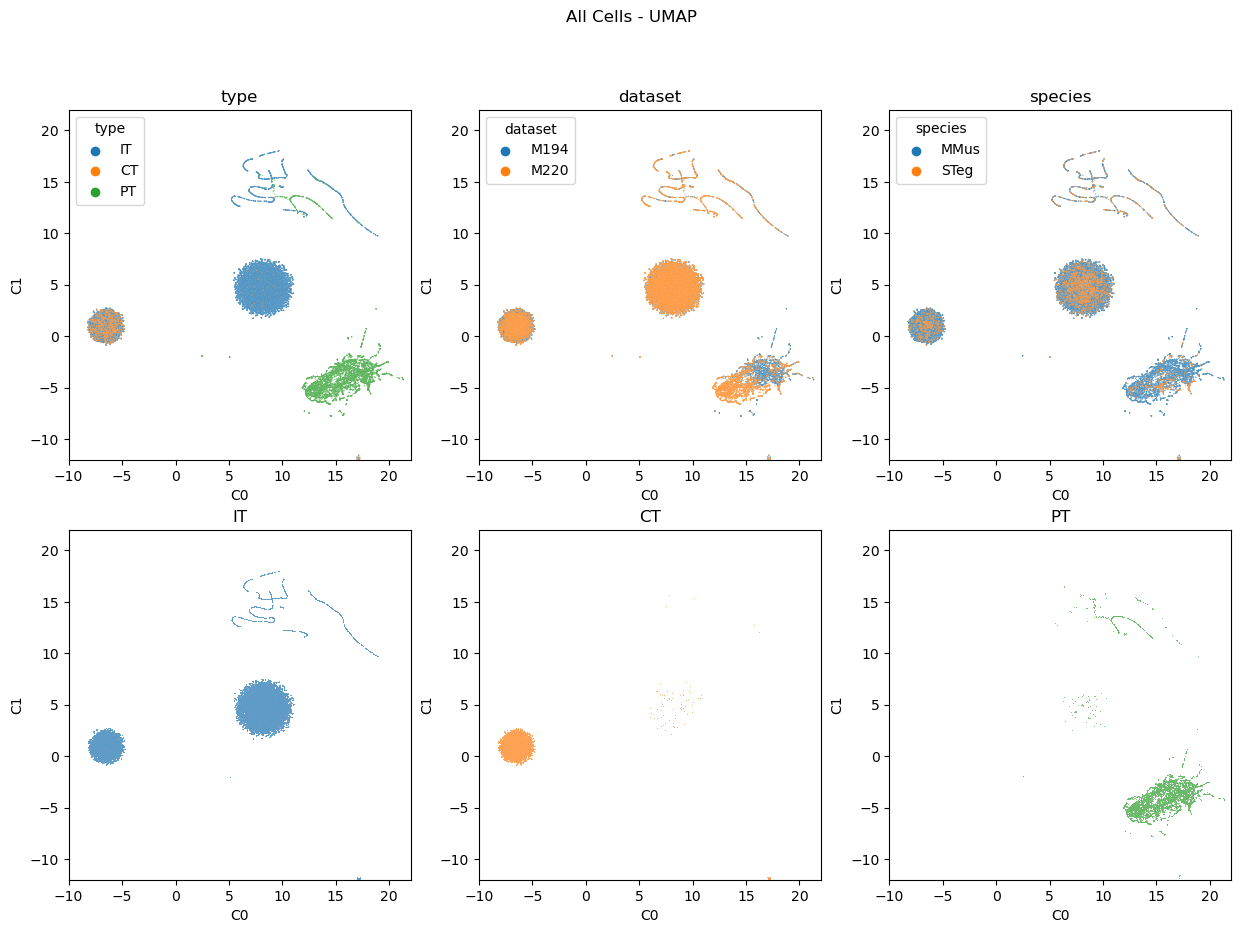

In [33]:
# try umap
umap_fit = umap.UMAP()
embedding = umap_fit.fit_transform(all_plot)
print(all_plot.shape)
print(embedding.shape)
plot = pd.DataFrame(embedding, columns = ["C0", "C1"])
plot['type'] = sorted_all['type']
plot['species'] = sorted_all['species']
plot["mice"] = sorted_all['mice']
plot["dataset"] = sorted_all['dataset']

print(sorted_all['type'].value_counts())

plot_vars = ["type", "dataset", "species"]
fig, axs = plt.subplots(2,3, figsize=(15,10))
i=0
for ax in axs[0,:]:
    sns.scatterplot(plot, x="C0", y="C1", hue=plot_vars[i], s=0.5, ax=ax)
    ax.set_xlim(-10,22)
    ax.set_ylim(-12,22)
    ax.set_title(plot_vars[i])
    i+=1

type_vars = ["IT", "CT", "PT"]
i=0
for ax in axs[1,:]:
    cell = type_vars[i]
    type_plot = plot[plot["type"] == cell]
    color = sns.color_palette("tab10")
    sns.scatterplot(type_plot, x="C0", y="C1", color=color[i], s=0.5, ax=ax)
    ax.set_title(cell)
    ax.set_xlim(-10,22)
    ax.set_ylim(-12,22)
    i+=1


plt.suptitle("All Cells - UMAP")

plt.show()

# UMAP IT cells

In [44]:
sorted_all.columns

Index(['OMCi', 'OMCc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS', 'type', 'mice', 'dataset', 'species'],
      dtype='object')

(57190, 9)
(57190, 2)
57190


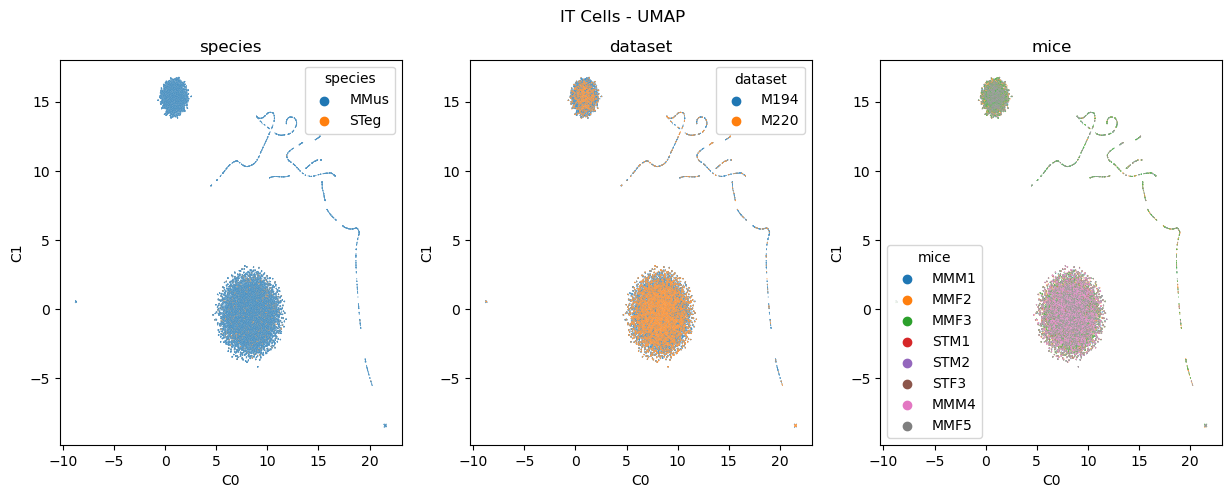

In [48]:
# try umap
idx = (sorted_all['type'] == "IT")
cell_plot = all_plot[idx]

umap_fit = umap.UMAP()
embedding = umap_fit.fit_transform(cell_plot)
print(cell_plot.shape)
print(embedding.shape)
plot = pd.DataFrame(embedding, columns = ["C0", "C1"])
plot['type'] = sorted_all['type'][idx]
plot['species'] = sorted_all['species'][idx]
plot["mice"] = sorted_all['mice'][idx]
plot["dataset"] = sorted_all['dataset'][idx]

print(cell_plot.shape[0])

plot_vars = ["species", "dataset", "mice"]
fig, axs = plt.subplots(1,3, figsize=(15,5))
i=0
for ax in axs.flat:
    sns.scatterplot(plot, x="C0", y="C1", hue=plot_vars[i], s=0.5, ax=ax)
    # ax.set_xlim(-10,22)
    # ax.set_ylim(-12,22)
    ax.set_title(plot_vars[i])
    i+=1

plt.suptitle("IT Cells - UMAP")

plt.show()

(9407, 9)
(9407, 2)


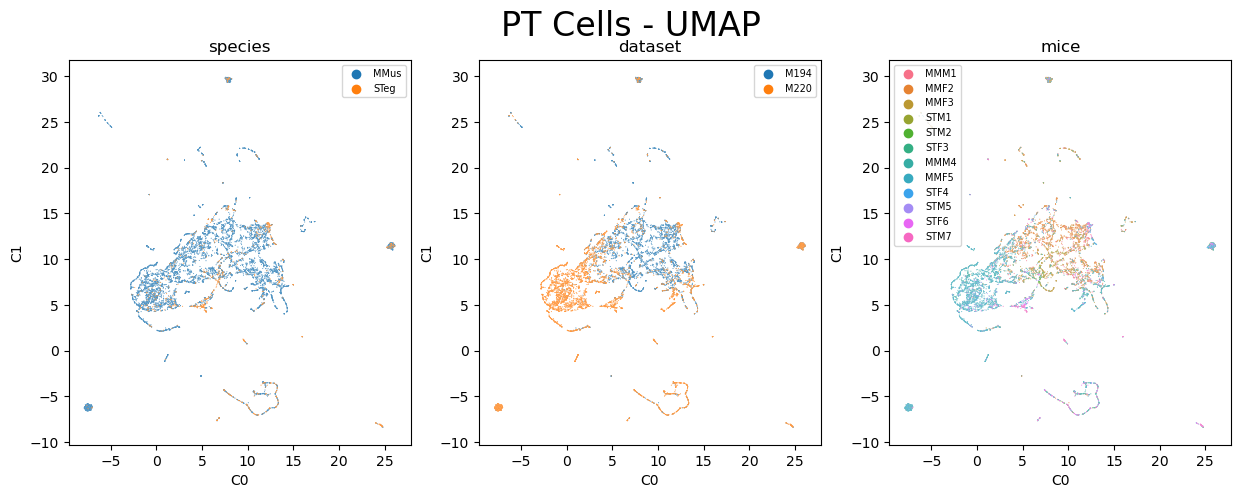

In [61]:
# try umap
idx = (sorted_all['type'] == "PT")
cell_plot = all_plot[idx]

umap_fit = umap.UMAP()
embedding = umap_fit.fit_transform(cell_plot)
print(cell_plot.shape)
print(embedding.shape)
plot = pd.DataFrame(embedding, columns = ["C0", "C1"])
plot['type'] = sorted_all['type'][idx].reset_index(drop=True)
plot['species'] = sorted_all['species'][idx].reset_index(drop=True)
plot["mice"] = sorted_all['mice'][idx].reset_index(drop=True)
plot["dataset"] = sorted_all['dataset'][idx].reset_index(drop=True)

plot_vars = ["species", "dataset", "mice"]
fig, axs = plt.subplots(1,3, figsize=(15,5))
i=0
for ax in axs.flat:
    sns.scatterplot(plot, x="C0", y="C1", hue=plot_vars[i], s=0.5, ax=ax)
    # ax.set_xlim(-10,22)
    # ax.set_ylim(-12,22)
    ax.set_title(plot_vars[i])
    ax.legend(fontsize=7)
    i+=1

plt.suptitle("PT Cells - UMAP", size=24)

plt.show()